# Network generation (and SIR Simulation)

In [1]:
import sys
if '../../' not in sys.path:
    sys.path.append('../../')
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from graph_generation import make_ebola_network
from dynamics import SimulationSIR, sample_seeds

Predefined network settings

In [5]:
n_nodes = 8000  # Desired number of nodes (we only keep the giant component, so actual number of nodes may be smaller)
p_in = 0.01  # Intra-district edge probability
p_out = {  # Inter-district edge probability
           'Guinea': 0.00215,
          'Liberia': 0.00300, 
     'Sierra Leone': 0.00315, 
    'inter-country': 0.0019
}

# Generate scaled graph with settings
G = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=None)

Run simulation on graph with predefined settings

In [6]:
# Sample seeds from the dataset (random set from infections seen before the given date, taking into account possible random recovery)
init_event_list = sample_seeds(graph=G, delta=1.0 / 11.4, method='data', max_date='2014-02-01')

# Initialize object
sir_obj = SimulationSIR(G, # Graph of individuals
                        beta=1.0 / 15.3,  # Infection rate (advised by literature)
                        delta=1.0 / 11.4,  # Recovery rate (advised by literature)
                        gamma=0.0, rho=0.0,  # Treatement values, should remain zero
                        verbose=False)

# Run the sumulation
sir_obj.launch_epidemic(init_event_list=init_event_list, max_time=120)

Add seed 10822 from district TONKOLILI - inf: 0.0, rec: 4.979392435084009 
Add seed 5122 from district GUECKEDOU - inf: 0.0, rec: 13.244372880445013 
Add seed 11266 from district WESTERN - inf: 0.0, rec: 7.936978815587459 
Add seed 5048 from district GUECKEDOU - inf: 0.0, rec: 19.006043994540654 


In [10]:
# creates a map between districts and blocks.
G_prime = copy.deepcopy(G)
blocks = []
districts = []
block_to_district = {}
district_to_block ={}
for k, v in enumerate(G_prime.nodes(data=True)):
    if v[1]['block'] not in blocks:
        blocks.append(v[1]['block'])
    if v[1]['district'] not in districts:
        districts.append(v[1]['district'])
    block_to_district[v[1]['block']] = v[1]['district']
    district_to_block[v[1]['district']] = v[1]['block']
print(len(blocks))
print(len(districts))

55
55


In [11]:
# Cuts all edges between the district and the rest of the graph.
def isolate_district(district_name, G_prime):
    block = district_to_block[district_name]
    for node in np.array(G_prime.nodes()):
        if G_prime.nodes()[node]['block'] == block:
            for neighbor in list(G_prime.neighbors(node)):
                if G_prime.nodes()[neighbor]['block'] != block:
                    G_prime.remove_edge(node, neighbor)

# TODO: write a function to isolate nodes in a specific district.

# eg:
isolate_district('TONKOLILI', G_prime)

<BarContainer object of 120 artists>

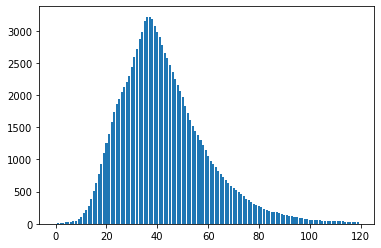

In [12]:
# Returns whether nodes are infected at some time or not.
def nodes_at_time(time, type, sir_obj):
    if type == 'ori':
        return sir_obj.nodes_at_time('I', time)
    elif type == 'cf':
        return (sir_obj.cf_rec > time) * (sir_obj.cf_inf < time)
    else:
        print('Invalid type.')

# eg:
ori_number_of_cases = [np.count_nonzero(nodes_at_time(i, 'ori', sir_obj)) for i in range(sir_obj.max_time)]
plt.bar(range(sir_obj.max_time), ori_number_of_cases)

In [23]:
percentage = 0.95
sir_obj.calculate_counterfactual(percentage * sir_obj.beta, G_prime)
print()
# Ignore the warnings :)

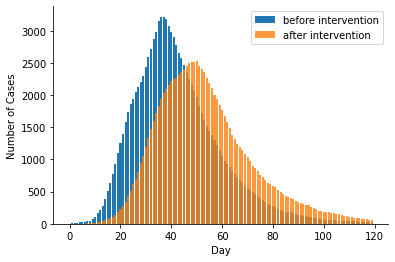

In [26]:
number_of_cases = [np.count_nonzero(nodes_at_time(i,'ori', sir_obj)) for i in range(sir_obj.max_time)]
cf_number_of_cases = [np.count_nonzero(nodes_at_time(i, 'cf', sir_obj)) for i in range(sir_obj.max_time)]
plt.bar(range(sir_obj.max_time), number_of_cases, label = 'before intervention')
plt.bar(range(sir_obj.max_time), cf_number_of_cases, label = 'after intervention', alpha = 0.8)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.xlabel('Day')
plt.ylabel('Number of Cases')
plt.legend()

In [ ]:
def plot_epidemic(G, sir, t):

    sus = np.vectorize(sir.idx_to_node.get)(np.where(sir.nodes_at_time('S', t))[0]).tolist()
    rec = np.vectorize(sir.idx_to_node.get)(np.where(sir.nodes_at_time('R', t))[0]).tolist()
    
    print('Plotting ...')
    
    pos = nx.spring_layout(G, k=0.1)

    plt.figure(figsize=(15, 15))
    nx.draw_networkx_edges(G, pos, alpha=1.0) # potentially draw infector pathways bigger

    nx.draw_networkx_nodes(G, pos, nodelist=sus,
                        node_size=50,
                        node_color='white',
                        linewidths=0.7,
                        edgecolors='black',
                        label='healthy')
    
    nx.draw_networkx_nodes(G, pos, nodelist=rec,
                        node_size=50,
                        node_color='grey',
                        linewidths=0.7,
                        edgecolors='black',
                        label='removed')
    plt.axis('off')
    plt.legend(numpoints=1)
    # plt.savefig('graph.pdf')


plot_epidemic(sir_obj.G, sir_obj, 30)